# Testing the model at the halo scale

This notebook is about testing the ability of the model to predict alignments at the halo level, between the
halo shape, central and satellites shapes

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from astropy.table import Table, join
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


# Step 1: Import the data

In [3]:
# Load mb2 sample
mb2 = Table.read('/data2/mb2_sample_groups.hdf5')

In [4]:
# Loading graphs
import pickle 

with open('/data2/graphs_groups_k8.pckl','rb') as f:
    gr = pickle.load(f)

In [5]:
# Loading indices of graph nodes
with open('/data2/sub_boxes_groups.pckl','rb') as f:
    sub_boxes = pickle.load(f)

In [6]:
# To make things easier we should get rid of all the nones at this stage
# We should also get rid of graphs larger than some desired size
sb = []
gmr = []
s = []
s2 = []
for i,m in enumerate(gr):
    if m is None:
        continue
    s.append( m.count_nonzero())
    s2.append(m.shape[0])
    if m.count_nonzero() > 1e4:
        continue
    sb.append(sub_boxes[i])
    gmr.append(m)
graph_mr = gmr
sub_boxes = sb

In [7]:
#We should check that the graphs are not stupid
import pygsp
G = pygsp.graphs.Graph(W=graph_mr[0], coords=array(mb2[['halos.x','halos.y']][sub_boxes[0]]).view(np.float64).reshape((-1,2)).astype(np.float32))

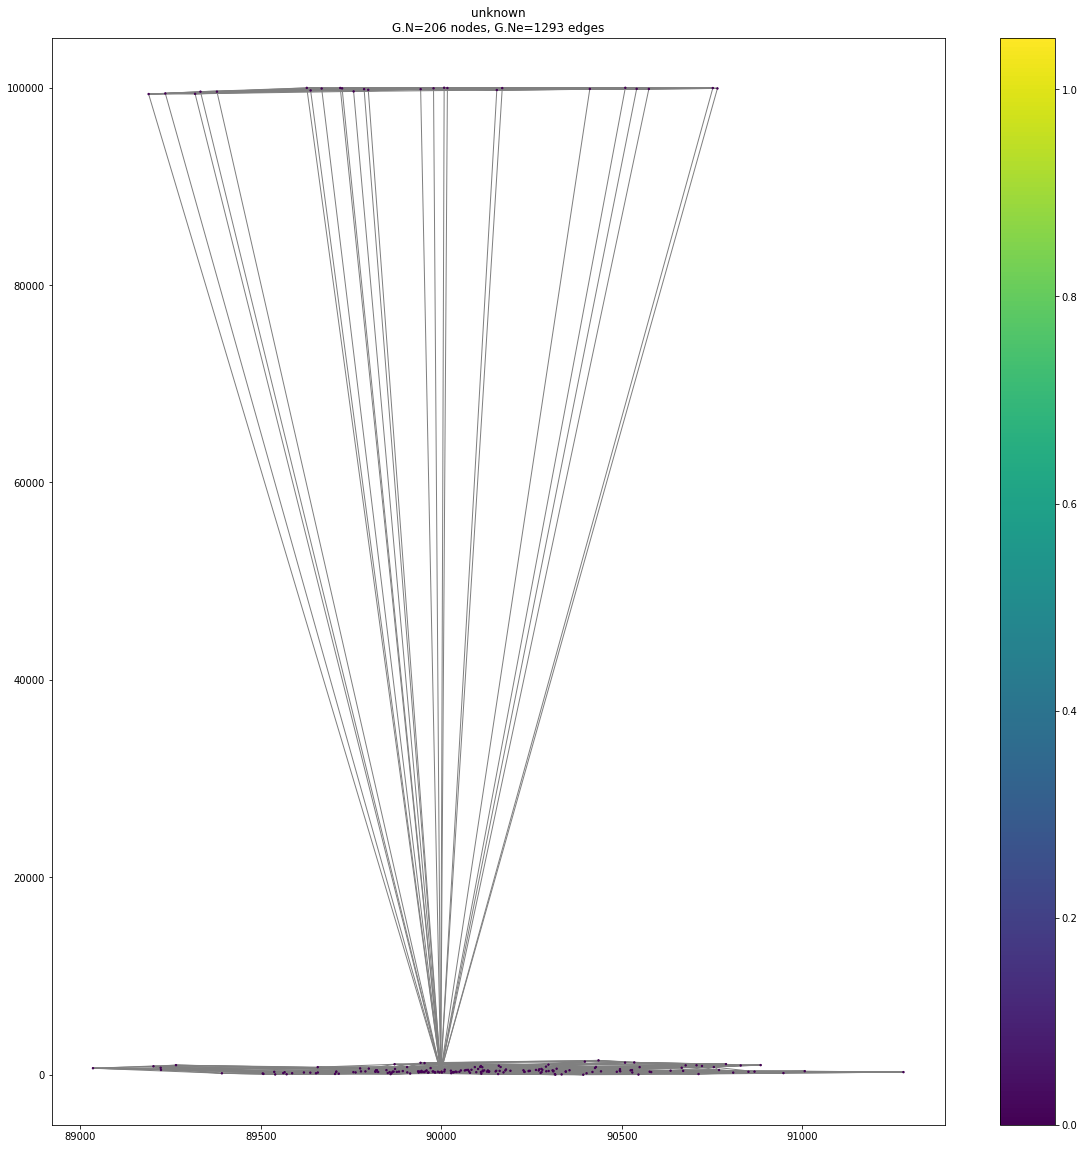

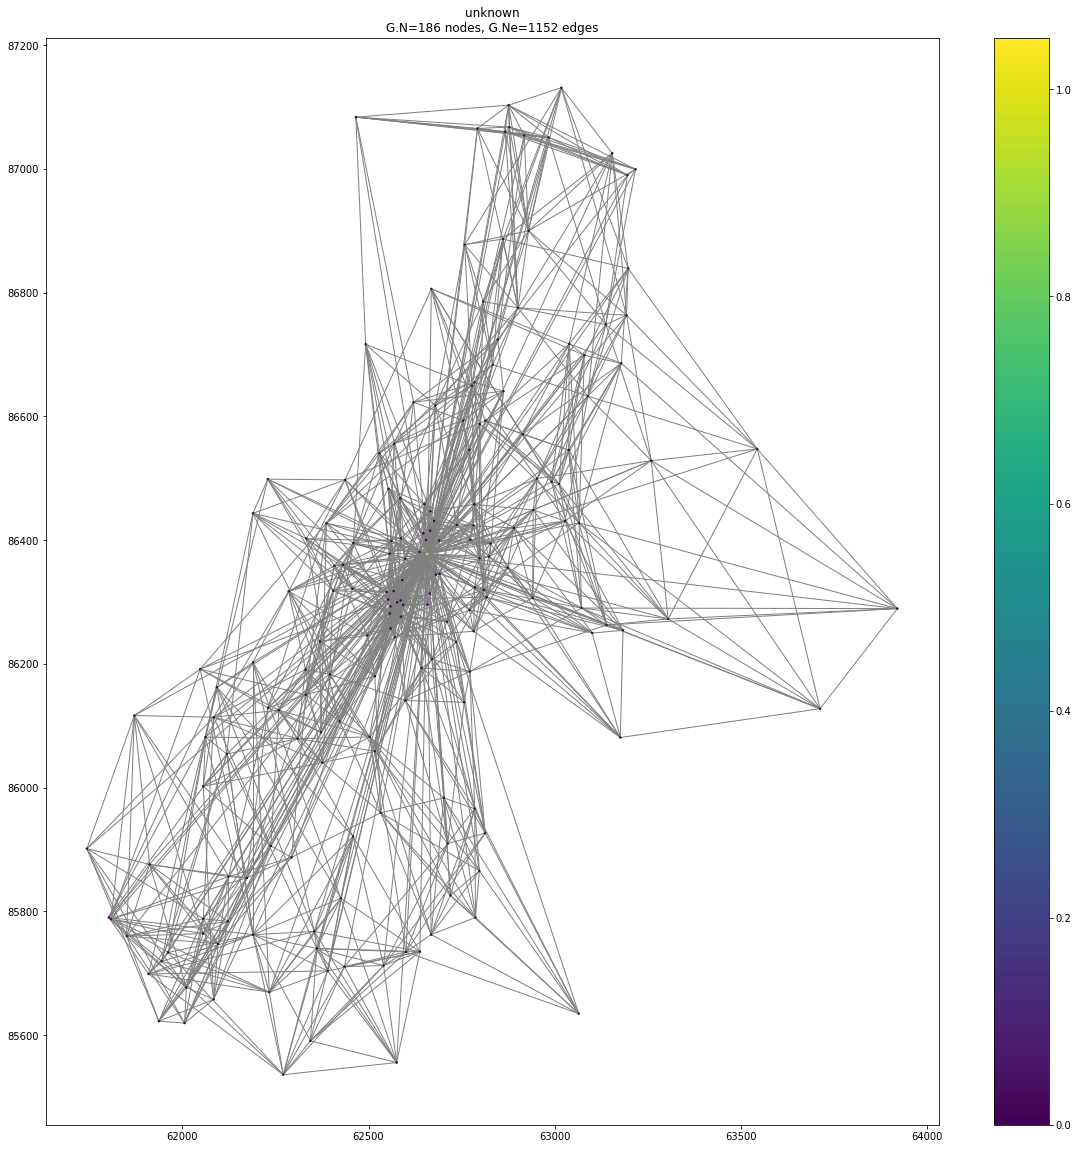

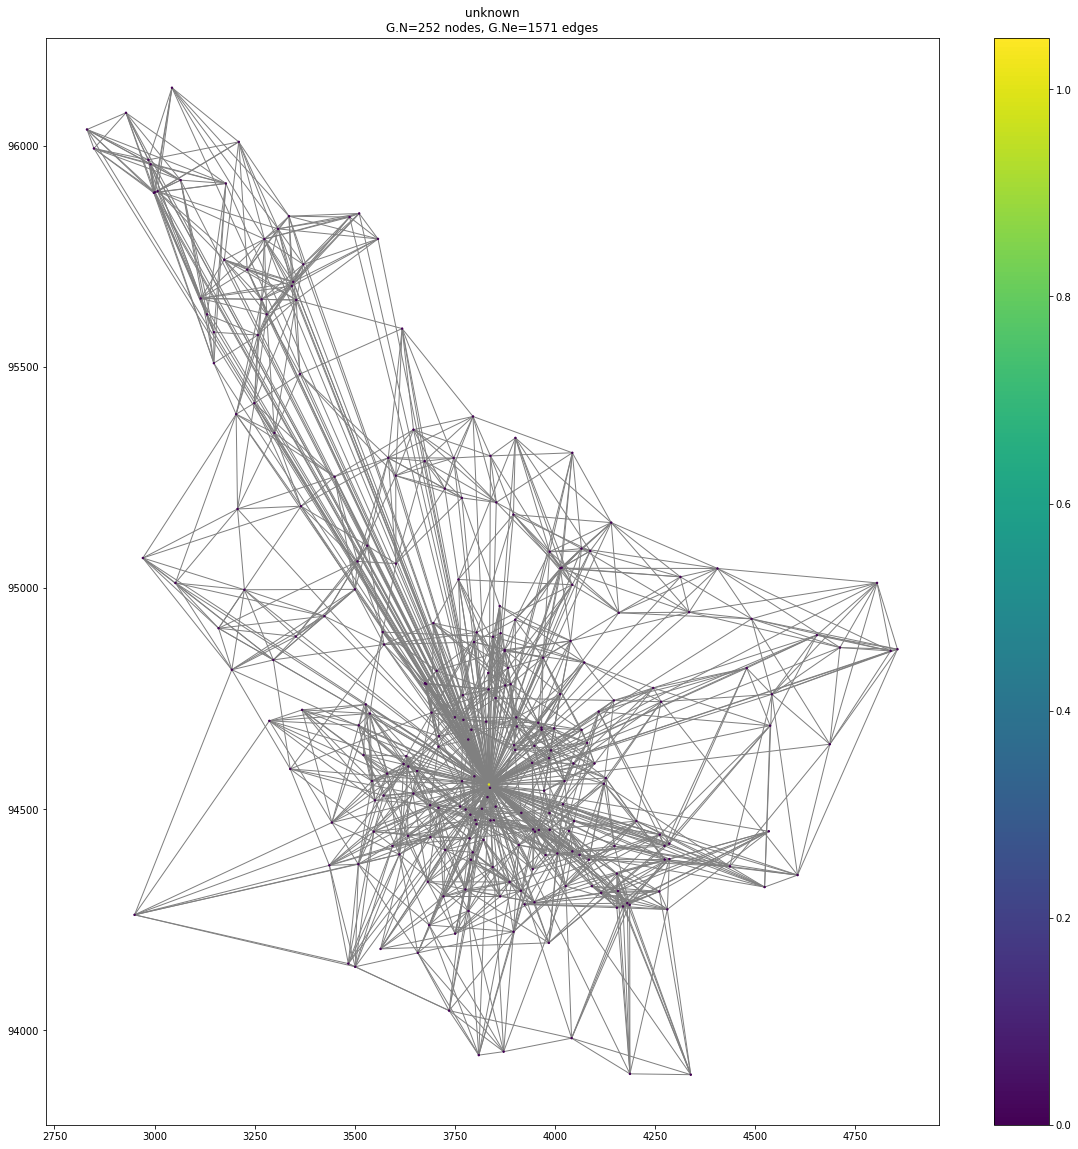

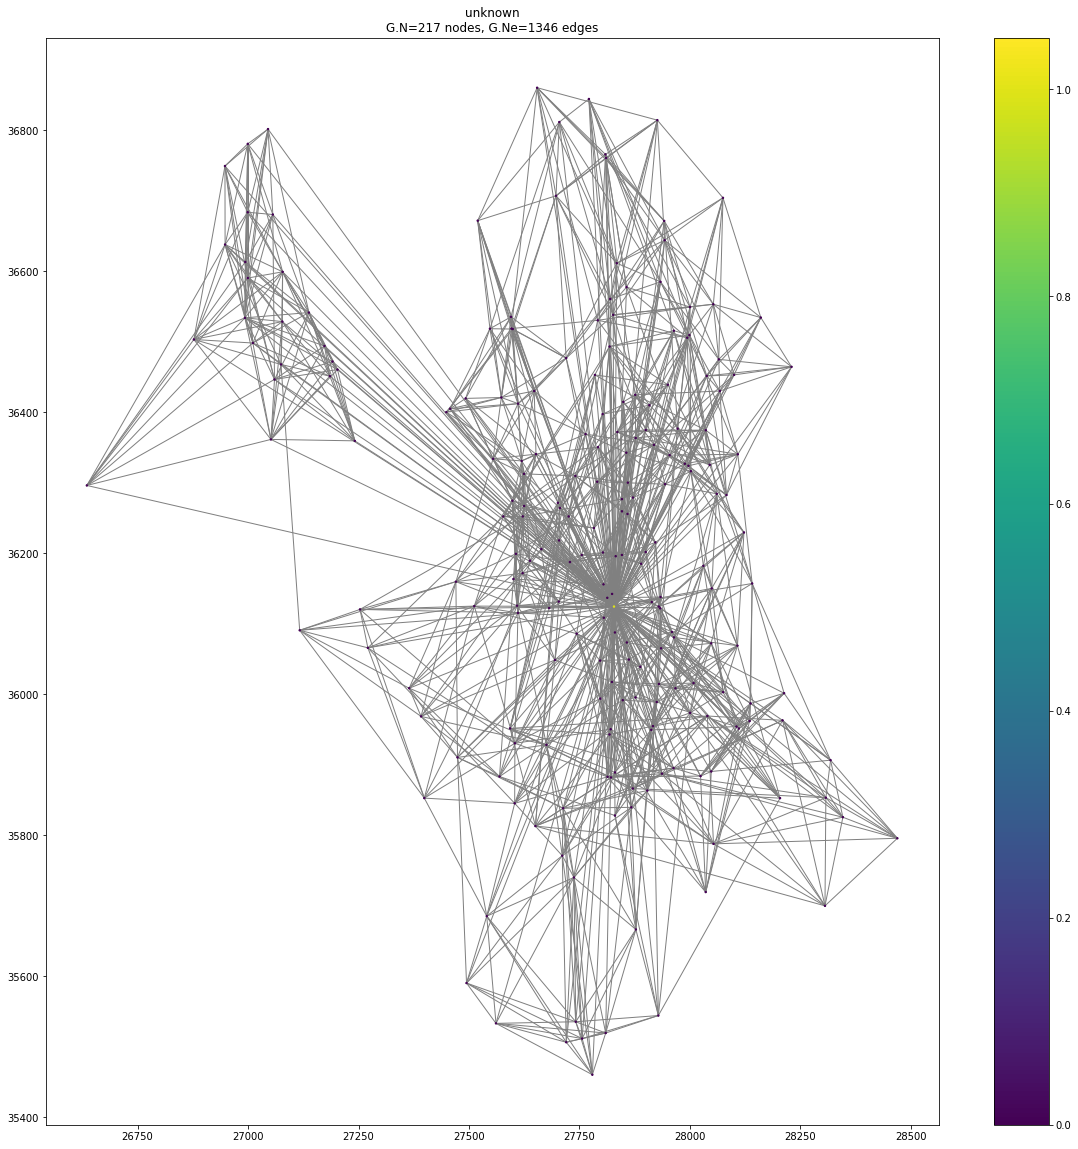

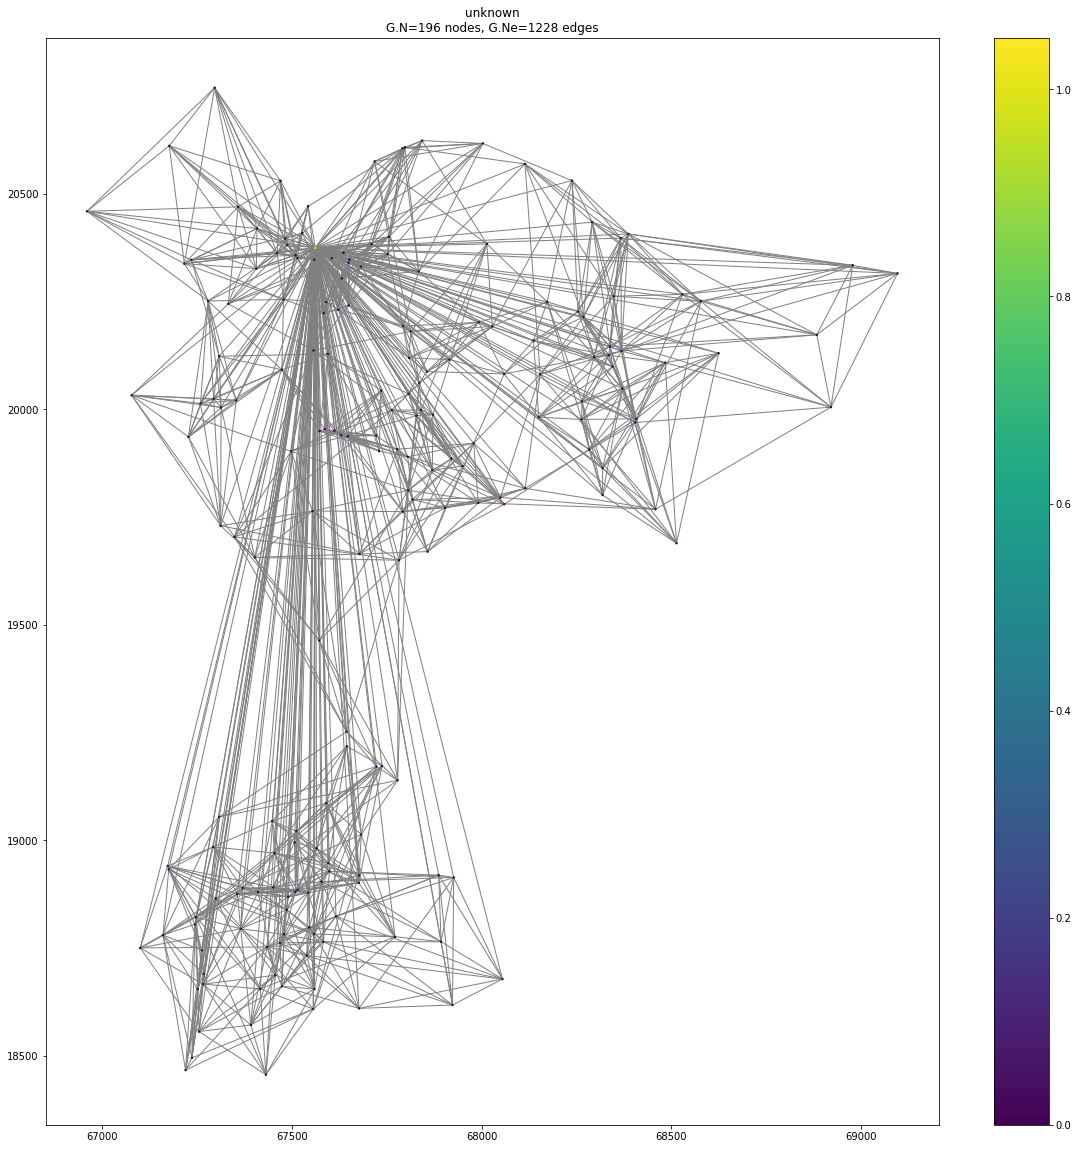

In [8]:
for ind in range(15,20):
    G = pygsp.graphs.Graph(W=graph_mr[ind], coords=array(mb2[['halos.x','halos.y']][sub_boxes[ind]]).view(np.float64).reshape((-1,2)).astype(np.float32))
    figure(figsize=(20,20))
    ax=plt.axes()
    G.plot_signal(signal=array(mb2['halos.central'][sub_boxes[ind]]).view(np.float64).reshape((-1,1)).astype(np.float32),
                 vertex_size=2, ax=ax)

In [9]:
from sklearn.preprocessing import RobustScaler
mb2['halos.m_dm_scaled'] = clip(RobustScaler().fit_transform(mb2['halos.m_dm'].reshape((-1,1))),-5,5).squeeze()
mb2['halos.m_star_scaled'] = clip(RobustScaler().fit_transform(mb2['halos.m_star'].reshape((-1,1))),-5,5).squeeze()

gid, idx, inv = unique(mb2['groups.groupId'], return_inverse=True, return_index=True)

mb2['host_x'] = mb2['groups.x'] - mb2['halos.x']
mb2['host_y'] = mb2['groups.y'] - mb2['halos.y']
mb2['host_z'] = mb2['groups.z'] - mb2['halos.z']

n = sqrt(mb2['host_x']**2 + mb2['host_y']**2 + mb2['host_z']**2 ) 

mb2['host_x'] = mb2['host_x']/n
mb2['host_y'] = mb2['host_y']/n
mb2['host_z'] = mb2['host_z']/n
mb2['host_r'] = n

In [10]:
import scipy.sparse as sp
sys.path.insert(0,'../')
from graphgan.utils import sparse_to_tuple, rand_rotation_matrix


feature_columns=['shapesDM.a3d_x', 'shapesDM.a3d_y','shapesDM.a3d_z',
                 'host_x', 'host_y', 'host_z',
                 'halos.central', 'halos.m_dm_scaled']

preXsp = np.array(mb2[['halos.x', 'halos.y', 'halos.z']]).view(np.float64).reshape((-1,3)).astype(np.float32)
preX = np.array(mb2[feature_columns]).view(np.float64).reshape((-1, len(feature_columns))).astype(np.float32)

# We need a function that will batch a group of graph into one
# This can be done by concatenating each multiresolution adjacency matrix, subsampling index and input signal
# Also need an operator that will do the spatial pooling into a batched tensor
def build_batch(inds, rotate=False):
    batch_size = len(inds)
    batch_xspatial = []
    batch_W = []
    batch_idx = []
    
    # Concatenate position array        
    Xspatial = concatenate([preXsp[sub_boxes[i]] for i in inds])

    # Concatenate adjacency matrices and transform to tuple format
    W = sp.block_diag([graph_mr[i] for i in inds])
    Wt = sparse_to_tuple(W)
    

    # Concatenate sub sampling 
    idx = []
    
    batch_xspatial.append(Xspatial/1000.)
    batch_W.append(Wt)
    batch_idx.append(idx)

    # Need to build the average pooling matrix at the last resolution
    data = concatenate([ones(graph_mr[i].shape[0])/graph_mr[i].shape[0] for i in inds])
    row =  concatenate([a*ones(graph_mr[i].shape[0]) for a,i in enumerate(inds)]).astype('int')
    col = arange(W.shape[0]).astype('int32')
    
    pooling_matrix = sparse_to_tuple(sp.coo_matrix((data, (row,col)), shape=(batch_size, W.shape[0])))

    X = [preX[sub_boxes[i]]  for i in inds]    
    X = np.concatenate(X)
    Y = X[:,0:6]
    X = X[:, 6:]
    
    
    # Apply rotations if needed
    if rotate:
        M = rand_rotation_matrix()
        Y[:,0:3] = Y[:,0:3].dot(M.T)
        Y[:,3:] = Y[:,3:].dot(M.T)
        batch_xspatial[0][:] = batch_xspatial[0].dot(M.T)
    else:
        pass
        #print("Not applying rotation !")
        
    return batch_W, batch_idx, batch_xspatial, pooling_matrix, X, Y

In [11]:
inds =[i for i in range(128)]

In [12]:
%timeit build_batch(inds)

9.79 ms ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
batch_W, batch_idx, batch_xspatial, pooling_matrix, X, Y =  build_batch(inds, rotate=True)

In [14]:
Y.shape

(16428, 6)

In [15]:
X.shape

(16428, 2)

## Step 2: Define the network

In [16]:
import tensorflow as tf

from graphgan.gradient_penalty import gradient_penaly

# Compute Directional Kernels
directions = np.zeros((3, 26))
filter_size=26
ind = 0
for i in range(3):
    for j in range(3):
        for k in range(3):
            if not (i==1 and j == 1 and k==1):
                directions[0,ind] = 1.0 * i - 1
                directions[1,ind] = 1.0 * j - 1
                directions[2,ind] = 1.0 * k - 1
                ind +=1
directions = directions.astype('float32')
directions /= np.sqrt((directions**2).sum(axis=0))

In [17]:
import tensorflow.contrib.slim as slim
from graphgan.layers import *
weighting='gate'
# How many fields are we generating
n_y = 6
scale=0.2 # In Mpc

tf.reset_default_graph()

# Define generator function
def conditional_generator_fn(inputs, is_training=True, filter_size=26):
    """
    This generator produces realistic 3D alignments conditioned on
    dark matter mass and LSS

    Args:
    inputs: tuple (adj, idn, x_spatial, pool, x, noise)

    Returns:
    Signal on the graph, y
    """
    W_1_0, W_2_0, W_3_0, xsp_0, pm_1,pm_2,pm_3, X, noise, Y = inputs

    adj = tf.SparseTensor(tf.cast(W_1_0, tf.int64),W_2_0,W_3_0)

    # Generator network
    # Computes 3D adjacency matrices for each multi-resolution level
    mr = spatial_adjacency(xsp_0, adj, directions, filter_size,
                           radial_scale=scale, radial_weighting=weighting,
                           learn_scale=True)

    # Input level, transforming all inputs features into a single channel
    # First we mix the inputs
    net = graph_conv2(tf.concat([noise, X],axis=1), mr, num_outputs=128, activation_fn=tf.nn.leaky_relu)
    
    mr = spatial_adjacency(xsp_0, adj, directions, filter_size,
                           radial_scale=scale, radial_weighting=weighting,
                           learn_scale=True)
    net = graph_conv2(net, mr, num_outputs=128,  activation_fn=tf.nn.leaky_relu)
    
    net = graph_conv2(net, mr, n_y*16, activation_fn=tf.nn.leaky_relu)

    # Let's constrain the output to lie on the sphere
    net_a3d = graph_conv2(net, mr, 3, activation_fn=None, one_hop=False)
    net_a3d = net_a3d / tf.sqrt(tf.reduce_sum(net_a3d**2, axis=1, keepdims=True))

    net_h3d = graph_conv2(net, mr, 3, activation_fn=None, one_hop=False)
    net_h3d = net_h3d / tf.sqrt(tf.reduce_sum(net_h3d**2, axis=1, keepdims=True))

    # Assemble output
    out_net = tf.concat([net_a3d, net_h3d], axis=1)

    return out_net

def conditional_discriminator_fn(y, conditioning):
    """
    Discriminator network that can tell if the galaxies are correctly aligned
    args:
    y: alignment signal
    conditioning: tuple (adj, idn, x_spatial, pool, x, noise)
    """
    W_1_0, W_2_0, W_3_0, xsp_0, pm_1,pm_2,pm_3, X, noise, Y = conditioning

    adj_0 = tf.SparseTensor(tf.cast(W_1_0, tf.int64),W_2_0,W_3_0)

    pool = tf.SparseTensor(tf.cast(pm_1, tf.int64), pm_2, pm_3)

    # Computes 3D adjacency matrices for each multi-resolution level
    mr = spatial_adjacency(xsp_0, adj_0, directions, filter_size,
                           radial_scale=scale, radial_weighting=weighting,
                           learn_scale=True)

    net = graph_conv2(tf.concat([y, X],axis=1), mr, num_outputs=64, activation_fn=tf.nn.leaky_relu)
    net = graph_conv2(net, mr, 64, activation_fn=tf.nn.leaky_relu)
    
    mr = spatial_adjacency(xsp_0, adj_0, directions, filter_size,
                           radial_scale=scale, radial_weighting=weighting,
                           learn_scale=True)
    net = graph_conv2(net, mr, 32, activation_fn=tf.nn.leaky_relu)
    net = graph_conv2(net, mr, 16, activation_fn=tf.nn.leaky_relu)

    # Apply spatial pooling
    net = tf.sparse_tensor_dense_matmul(pool, net)

    net = slim.fully_connected(net, 1, activation_fn=None)

    return net

In [18]:
def mapping_function(inds, rotate=True):
    def extract_batch(inds):
        batch_W, batch_idx, batch_xspatial, pooling_matrix, X, Y = build_batch(inds, rotate=rotate)
        W_1_0, W_2_0, W_3_0 = batch_W[0]
        pm_1,pm_2,pm_3 = pooling_matrix
        X = X.astype('float32')
        Y = Y.astype('float32')
        noise = randn(len(X),32).astype('float32')
        return (W_1_0,W_2_0.astype('float32'), W_3_0,
                batch_xspatial[0], 
                pm_1,pm_2.astype('float32'),pm_3,
                X, Y, noise)


    W_1_0, W_2_0, W_3_0, xsp_0, pm_1,pm_2,pm_3, X, Y, noise = tf.py_func(extract_batch, [inds],
                        [tf.int32, tf.float32, tf.int64, 
                         tf.float32,
                         tf.int32, tf.float32, tf.int64,
                         tf.float32, tf.float32, tf.float32])

    W_1_0.set_shape([None,2])
    W_2_0.set_shape([None])
    W_3_0.set_shape([2])

    xsp_0.set_shape([None,3])

    pm_1.set_shape([None,2])
    pm_2.set_shape([None])
    pm_3.set_shape([2])

    X.set_shape([None, 2]) #instead of 26
    noise.set_shape([None,32])
    Y.set_shape([None, 6])

    return W_1_0, W_2_0, W_3_0, xsp_0, pm_1,pm_2,pm_3, X, noise, Y

def train_input_fn():
    """
    Training function that generates the graph structure
    in addition to the signals.
    """
    dataset = tf.data.Dataset.range(len(graph_mr))
    dataset = dataset.repeat().shuffle(10000).batch(64)
    dataset = dataset.map(mapping_function)
    dataset = dataset.prefetch(16)
    iterator = dataset.make_one_shot_iterator()
    data = iterator.get_next()
    return  data, data[-1]

def test_input_fn():
    """
    Training function that generates the graph structure
    in addition to the signals.
    """
    dataset = tf.data.Dataset.range(len(graph_mr))
    dataset = dataset.batch(1)
    dataset = dataset.map(lambda *args: mapping_function(*args, rotate=False))
    dataset = dataset.prefetch(16)
    iterator = dataset.make_one_shot_iterator()
    data = iterator.get_next()
    return  data, data[-1]

In [36]:
import tensorflow.contrib.gan as tfgan
from tensorflow.contrib.gan.python import namedtuples

my_config = tf.estimator.RunConfig(
    save_checkpoints_steps = 2000,
    keep_checkpoint_max = 100,       # Retain the 10 most recent checkpoints.
)


def silly_custom_discriminator_loss(gan_model, add_summaries=True):
    return tf.reduce_mean(gan_model.discriminator_real_outputs**2)


# Initialize GANEstimator with options and hyperparameters.
gan_estimator = tfgan.estimator.GANEstimator(
    generator_fn=conditional_generator_fn,
    discriminator_fn=conditional_discriminator_fn,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=lambda *args, **kwargs: (tfgan.losses.wasserstein_discriminator_loss(*args, **kwargs) + 
                                                   10.*gradient_penaly(*args, **kwargs)+
                                                   0.001*silly_custom_discriminator_loss(*args, **kwargs)),   
    generator_optimizer=tf.train.AdamOptimizer(0.0001, beta1=0., beta2=0.9),
    discriminator_optimizer=tf.train.AdamOptimizer(0.0001, beta1=0., beta2=0.9),
    get_hooks_fn=tfgan.get_sequential_train_hooks(train_steps=namedtuples.GANTrainSteps(1, 5)),
    model_dir='/data2/graphs4ia/test1', 
    config=my_config)

INFO:tensorflow:Using config: {'_model_dir': '/data2/graphs4ia/test1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 2000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 100, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa93a822940>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [20]:
gan_estimator.train(train_input_fn, steps=3000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /data2/graphs4ia/test1/model.ckpt.
INFO:tensorflow:loss = 0.5796032, step = 1
INFO:tensorflow:global_step/sec: 2.537
INFO:tensorflow:loss = -3.3070054, step = 101 (39.417 sec)
INFO:tensorflow:global_step/sec: 2.84904
INFO:tensorflow:loss = -2.0118077, step = 201 (35.100 sec)
INFO:tensorflow:global_step/sec: 2.84446
INFO:tensorflow:loss = -1.0521963, step = 301 (35.156 sec)
INFO:tensorflow:global_step/sec: 2.85768
INFO:tensorflow:loss = -0.26385567, step = 401 (34.994 sec)
INFO:tensorflow:global_step/sec: 2.84473
INFO:tensorflow:loss = 0.29986197, step = 501 (35.153 sec)
INFO:tensorflow:global_step/sec: 2.85024
INFO:tensorflow:loss = -0.27684835, step = 601 (35.085 sec)
INFO:tensorflow:global_step/sec: 2.8399

In [62]:
gan_estimator.train(train_input_fn, steps=100000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/graphs4ia/test1/model.ckpt-35000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 35000 into /data2/graphs4ia/test1/model.ckpt.
INFO:tensorflow:loss = 0.062168486, step = 35001
INFO:tensorflow:global_step/sec: 2.53599
INFO:tensorflow:loss = 0.20525779, step = 35101 (39.433 sec)
INFO:tensorflow:global_step/sec: 2.87862
INFO:tensorflow:loss = -0.06336198, step = 35201 (34.739 sec)
INFO:tensorflow:global_step/sec: 2.88156
INFO:tensorflow:loss = 0.013224209, step = 35301 (34.703 sec)
INFO:tensorflow:global_step/sec: 2.86863
INFO:tensorflow:loss = 0.1512936, step = 35401 (34.860 sec)
INFO:tensorflow:global_step/sec: 2.88187
INFO:tensorflow:loss = 0.4312731, step = 35501 (34.700 sec)
INFO:tensorflow:global_step/sec: 2.87

INFO:tensorflow:global_step/sec: 2.88297
INFO:tensorflow:loss = -0.0097538065, step = 42401 (34.687 sec)
INFO:tensorflow:global_step/sec: 2.88983
INFO:tensorflow:loss = -0.08537955, step = 42501 (34.604 sec)
INFO:tensorflow:global_step/sec: 2.88391
INFO:tensorflow:loss = -0.0251598, step = 42601 (34.675 sec)
INFO:tensorflow:global_step/sec: 2.88576
INFO:tensorflow:loss = -0.13727146, step = 42701 (34.653 sec)
INFO:tensorflow:global_step/sec: 2.87458
INFO:tensorflow:loss = -0.17306763, step = 42801 (34.788 sec)
INFO:tensorflow:global_step/sec: 2.87677
INFO:tensorflow:loss = 0.002657257, step = 42901 (34.761 sec)
INFO:tensorflow:Saving checkpoints for 43000 into /data2/graphs4ia/test1/model.ckpt.
INFO:tensorflow:global_step/sec: 1.90062
INFO:tensorflow:loss = 0.13281927, step = 43001 (52.615 sec)
INFO:tensorflow:global_step/sec: 2.88386
INFO:tensorflow:loss = 0.07306142, step = 43101 (34.675 sec)
INFO:tensorflow:global_step/sec: 2.87951
INFO:tensorflow:loss = -0.019597156, step = 43201 (

KeyboardInterrupt: 

In [63]:
pred = gan_estimator.predict(input_fn=test_input_fn, yield_single_examples=False)
toto = concatenate([next(pred) for i in range(1000)])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/graphs4ia/test1/model.ckpt-49000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [64]:
sid  = concatenate([mb2[sub_boxes[i]]['halos.subfindId'] for i in range(1000)])
sids, inds = unique(sid, return_index=True)
sid= sid[inds]
cx = concatenate([mb2[sub_boxes[i]]['halos.x'] for i in range(1000)])[inds]
cy = concatenate([mb2[sub_boxes[i]]['halos.y'] for i in range(1000)])[inds]
cz = concatenate([mb2[sub_boxes[i]]['halos.z'] for i in range(1000)])[inds]
m_dm = concatenate([mb2[sub_boxes[i]]['halos.m_dm'] for i in range(1000)])[inds]
a_x0 = concatenate([mb2[sub_boxes[i]]['shapesDM.a3d_x'] for i in range(1000)])[inds]
a_y0 = concatenate([mb2[sub_boxes[i]]['shapesDM.a3d_y'] for i in range(1000)])[inds]
a_z0 = concatenate([mb2[sub_boxes[i]]['shapesDM.a3d_z'] for i in range(1000)])[inds]
as_x0 = concatenate([mb2[sub_boxes[i]]['shapesStar.a3d_x'] for i in range(1000)])[inds]
as_y0 = concatenate([mb2[sub_boxes[i]]['shapesStar.a3d_y'] for i in range(1000)])[inds]
as_z0 = concatenate([mb2[sub_boxes[i]]['shapesStar.a3d_z'] for i in range(1000)])[inds]
h_x0 = concatenate([mb2[sub_boxes[i]]['host_x'] for i in range(1000)])[inds]
h_y0 = concatenate([mb2[sub_boxes[i]]['host_y'] for i in range(1000)])[inds]
h_z0 = concatenate([mb2[sub_boxes[i]]['host_z'] for i in range(1000)])[inds]
x0 = concatenate([mb2[sub_boxes[i]]['halos.x'] for i in range(1000)])[inds]
y0 = concatenate([mb2[sub_boxes[i]]['halos.y'] for i in range(1000)])[inds]
z0 = concatenate([mb2[sub_boxes[i]]['halos.z'] for i in range(1000)])[inds]
gid  = concatenate([mb2[sub_boxes[i]]['groups.subfindId'] for i in range(1000)])[inds]
isc = concatenate([mb2[sub_boxes[i]]['halos.central'] for i in range(1000)])[inds]
r = concatenate([mb2[sub_boxes[i]]['host_r'] for i in range(1000)])[inds]

In [65]:
toto = toto[inds]
a_x = toto[:,0]
a_y = toto[:,1]
a_z = toto[:,2]
h_x = toto[:,3]
h_y = toto[:,4]
h_z = toto[:,5]

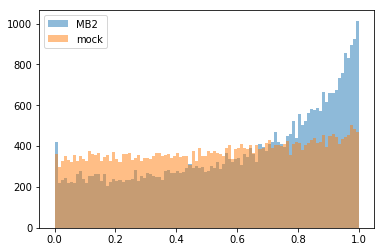

In [68]:
dtS = (a_x0 * h_x0 +  a_y0 * h_y0  + a_z0 * h_z0)
hist(abs(dtS),100,alpha=0.5, label='MB2');
dtS = (h_x0 * a_x +  h_y0 * a_y  + h_z0 * a_z)
hist(abs(dtS),100,alpha=0.5, label='mock');
legend()

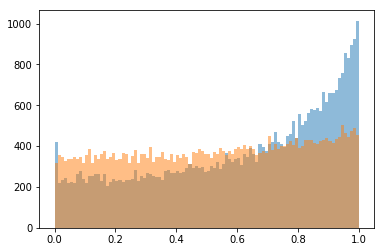

In [69]:
dtS = (a_x0 * h_x0 +  a_y0 * h_y0  + a_z0 * h_z0)
hist(abs(dtS),100,alpha=0.5, label='MB2');
dtS = (h_x * a_x +  h_y * a_y  + h_z * a_z)
hist(abs(dtS),100,alpha=0.5, label='mock');

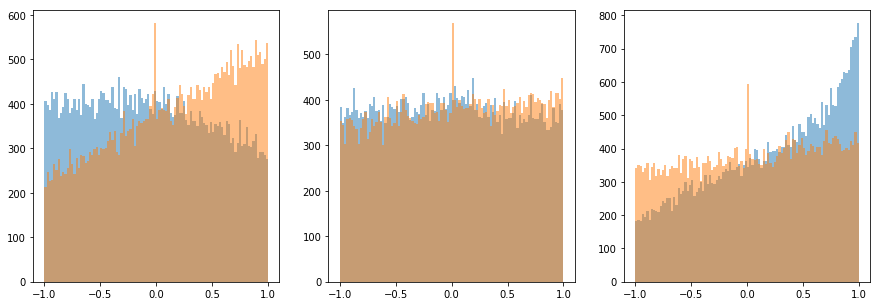

In [52]:
figure(figsize=(15,5))
subplot(131)
hist(a_x,100,alpha=0.5);
hist(a_x0,100,alpha=0.5);
subplot(132)
hist(a_y,100,alpha=0.5);
hist(a_y0,100,alpha=0.5);
subplot(133)
hist(a_z,100,alpha=0.5);
hist(a_z0,100,alpha=0.5);

In [27]:
dt0 = (h_x0 * a_x0 +  h_y0 * a_y0  + h_z0 * a_z0)
dt = (h_x0 * a_x +  h_y0 * a_y  + h_z0 * a_z)

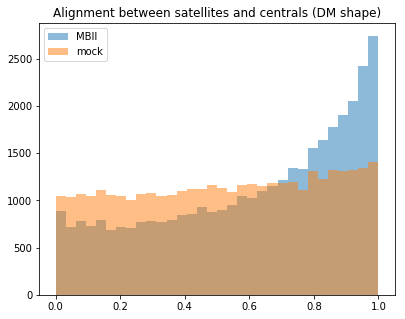

In [28]:
m = isc == 0

figure(figsize=(14,5))
subplot(121)
hist(abs(dt0[m]),32,alpha=0.5, label='MBII');
hist(abs(dt[m]),32,alpha=0.5, label='mock');
legend()
title('Alignment between satellites and centrals (DM shape)');

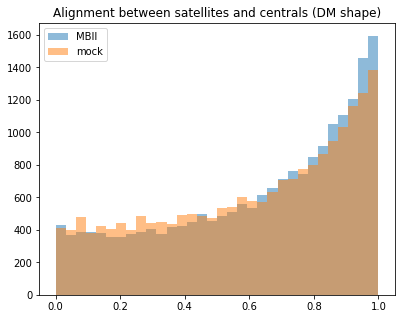

In [51]:
m = (isc == 0) & (r > 200)

figure(figsize=(14,5))
subplot(121)
hist(abs(dt0[m]),32,alpha=0.5, label='MBII');
hist(abs(dt[m]),32,alpha=0.5, label='mock');
legend()
title('Alignment between satellites and centrals (DM shape)');

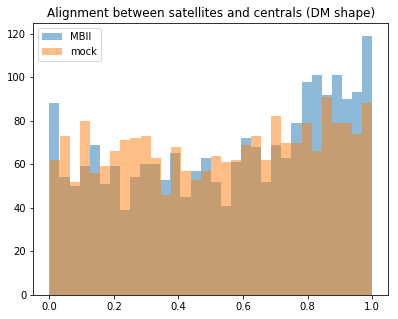

In [47]:
m = (isc == 0) & (r < 100)

figure(figsize=(14,5))
subplot(121)
hist(abs(dt0[m]),32,alpha=0.5, label='MBII');
hist(abs(dt[m]),32,alpha=0.5, label='mock');
legend()
title('Alignment between satellites and centrals (DM shape)');

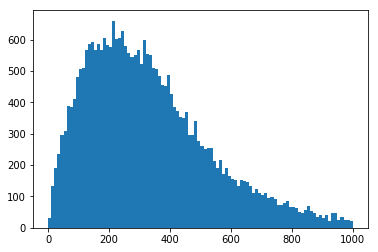

In [44]:
hist(r, 100, range=[0,1000]);

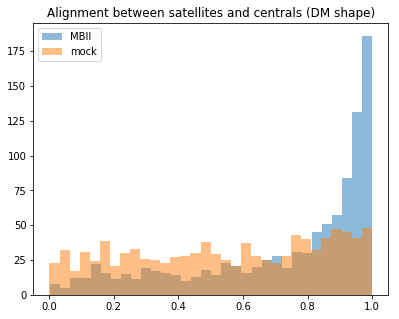

In [29]:
m = isc == 1

figure(figsize=(14,5))
subplot(121)
hist(abs(dt0[m]),32,alpha=0.5, label='MBII');
hist(abs(dt[m]),32,alpha=0.5, label='mock');
legend()
title('Alignment between satellites and centrals (DM shape)');

NameError: name 'dt0S' is not defined

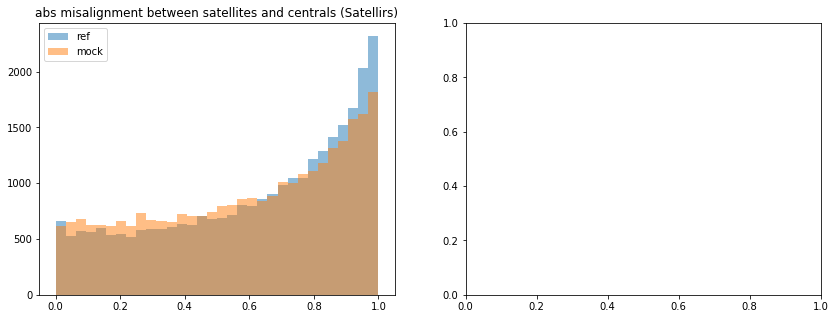

In [30]:
figure(figsize=(14,5))
subplot(121)
hist(abs(dt0),32,alpha=0.5, label='ref');
hist(abs(dt),32,alpha=0.5, label='mock');
legend()
title('abs misalignment between satellites and centrals (Satellirs)')
subplot(122)
hist(abs(dt0S),32,alpha=0.5, label='ref');
hist(abs(dtS),32,alpha=0.5, label='mock');
legend()
title('abs misalignment between satellites and centrals (gal shape)');

In [63]:
dt0 = (h_x * a_x0 +  h_y * a_y0  + h_z * a_z0)
dt = (h_x * a_x +  h_y * a_y  + h_z * a_z)

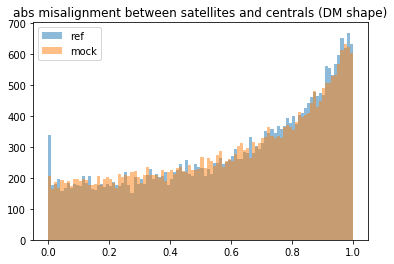

In [64]:
hist(abs(dt0),100,alpha=0.5, label='ref');
hist(abs(dt),100,alpha=0.5, label='mock');
legend()
title('abs misalignment between satellites and centrals (DM shape)');

Very nice!

Ok, so... now, let's see if we can compute some 2pt functions

In [70]:
from halotools.mock_observables.alignments import ed_3d,ee_3d, ed_3d_one_two_halo_decomp

In [71]:
rbins = np.logspace(-1.5,2,20)

m =  (abs(a_x0) > 0) 

# First compute reference correlation from MB2
pos1 = array([x0, y0, z0]).T /1000.
or1  =array([a_x0,a_y0,a_z0]).T
ed1 = ed_3d(pos1[m], or1[m], pos1,  rbins, period=None)

In [72]:
or2  =array([a_x,a_y,a_z]).T

In [73]:
ed1h,ed2h = ed_3d_one_two_halo_decomp(pos1[m], or1[m], gid[m],  pos1[m], gid[m], rbins, period=None)
ed1h2,ed2h2 = ed_3d_one_two_halo_decomp(pos1[m], or2[m], gid[m],  pos1[m], gid[m], rbins, period=None)

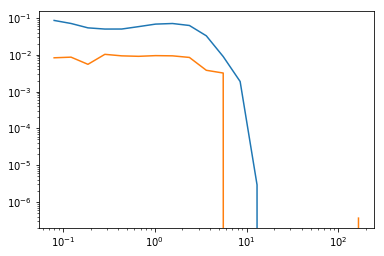

In [74]:
loglog(rbins[1:] + rbins[:-1], ed1h)
loglog(rbins[1:] + rbins[:-1], ed1h2)

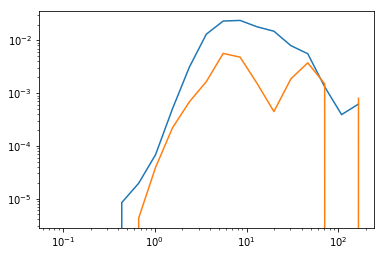

In [77]:
loglog(rbins[1:] + rbins[:-1], ed2h)
loglog(rbins[1:] + rbins[:-1], ed2h2)

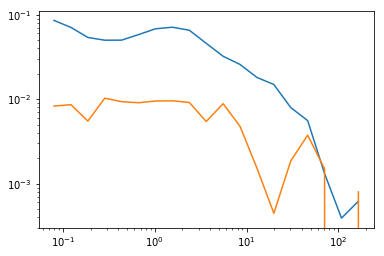

In [78]:
loglog(rbins[1:] + rbins[:-1], ed1h+ed2h)
loglog(rbins[1:] + rbins[:-1], ed1h2+ed2h2)

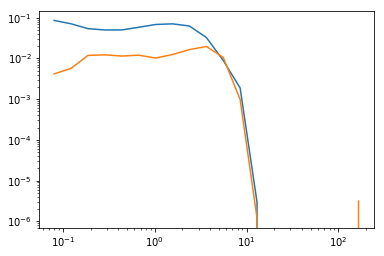

In [59]:
loglog(rbins[1:] + rbins[:-1], ed1h)
loglog(rbins[1:] + rbins[:-1], ed1h2)

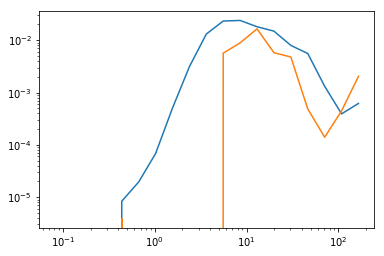

In [60]:
loglog(rbins[1:] + rbins[:-1], ed2h)
loglog(rbins[1:] + rbins[:-1], ed2h2)

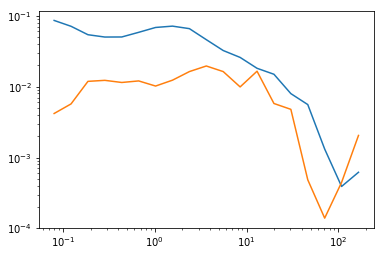

In [61]:
loglog(rbins[1:] + rbins[:-1], ed1h+ed2h)
loglog(rbins[1:] + rbins[:-1], ed1h2+ed2h2)

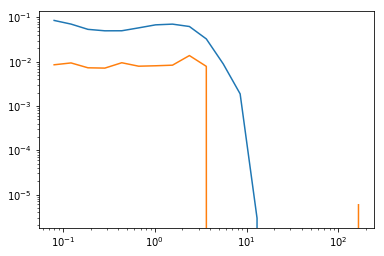

In [33]:
loglog(rbins[1:] + rbins[:-1], ed1h)
loglog(rbins[1:] + rbins[:-1], ed1h2)

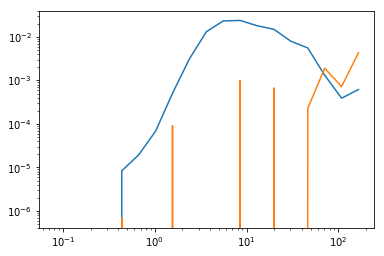

In [34]:
loglog(rbins[1:] + rbins[:-1], ed2h)
loglog(rbins[1:] + rbins[:-1], ed2h2)

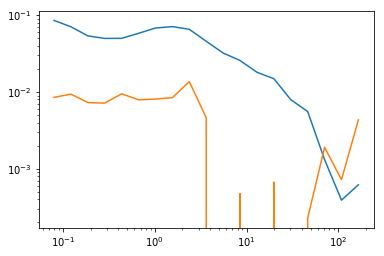

In [35]:
loglog(rbins[1:] + rbins[:-1], ed1h+ed2h)
loglog(rbins[1:] + rbins[:-1], ed1h2+ed2h2)

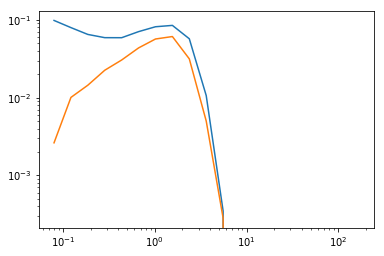

In [35]:
loglog(rbins[1:] + rbins[:-1], ed1h)
loglog(rbins[1:] + rbins[:-1], ed1h2)

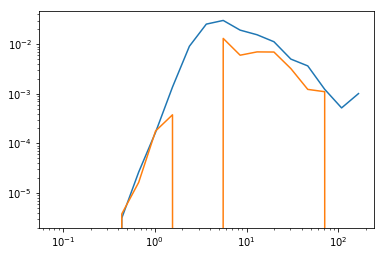

In [36]:
loglog(rbins[1:] + rbins[:-1], ed2h)
loglog(rbins[1:] + rbins[:-1], ed2h2)

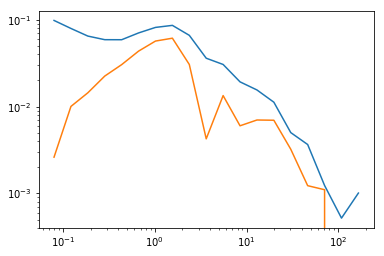

In [37]:
loglog(rbins[1:] + rbins[:-1], ed1h+ed2h)
loglog(rbins[1:] + rbins[:-1], ed1h2+ed2h2)

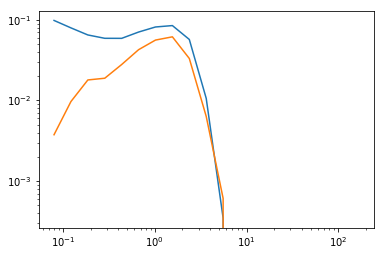

In [107]:
loglog(rbins[1:] + rbins[:-1], ed1h)
loglog(rbins[1:] + rbins[:-1], ed1h2)

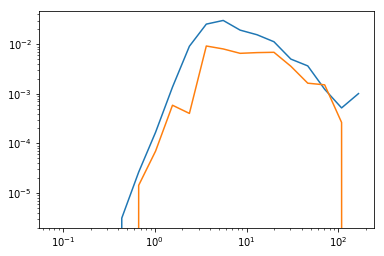

In [108]:
loglog(rbins[1:] + rbins[:-1], ed2h)
loglog(rbins[1:] + rbins[:-1], ed2h2)

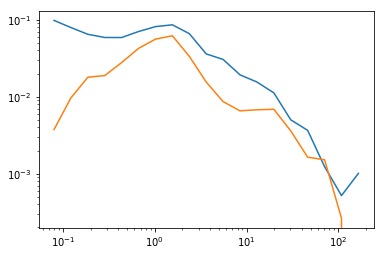

In [109]:
loglog(rbins[1:] + rbins[:-1], ed1h+ed2h)
loglog(rbins[1:] + rbins[:-1], ed1h2+ed2h2)